# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [38]:
import pandas as pd
import numpy as np
import gzip
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from pymorphy2 import MorphAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
with gzip.open("data/data.csv.gz", 'rb') as fr, \
            open('data.csv', 'wb') as fw:
    bytes_data = fr.read()
    fw.write(bytes_data)

data = bytes_data.decode('utf-8')

In [2]:
df_comments = pd.read_csv("data.csv")

In [3]:
df_comments.head()

body  \
0  &lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...   
1  &lt;p&gt;При возврате просроченной задолженнос...   
2  &lt;p&gt;07.09.22 ю была оформлена кредитная к...   
3  &lt;p&gt;Новый год начинается с приятностей)&l...   
4  &lt;p&gt;Увидела на сайте Газпромбанка акцию с...   

                                               title  rating      bank_name  \
0                             Заблокировали средства       1      Еком Банк   
1                 Возврат просроченной задолженномти       1  Тинькофф Банк   
2  Ошибочное начисление комиссии, затягивание про...       1  Банк Открытие   
3                    Клиентоориентиванность 10 из 10       5  Тинькофф Банк   
4  Как Газпромбанк обманывает клиентов с акционны...       1    Газпромбанк   

                  date  
0  2023-01-03 12:46:11  
1  2023-01-03 12:31:46  
2  2023-01-03 12:23:11  
3  2023-01-03 12:16:07  
4  2023-01-03 12:12:36

In [5]:
# Признак - максимальное количество ! рядом (для дальнейшей оптимизации модели и расчёта на основе метрики качества)
def max_VoscZ(arr):
    max = 0
    for w in arr:
        j = 0
        while j < len(w) and w[j] == '!':
            j = j + 1
        if j > max:
            max = j
    return max 

# Признак - количество слов состоящих только из !
def only_VoscZ(arr): 
    cnt = 0
    for w in arr:
        j = 0
        while j < len(w) and w[j] == '!':
            j = j + 1
        if j > 0:
            cnt = cnt + 1
    return cnt 

# Признак - количество уникальных слов
def unique_word(arr):    
    return len(np.unique(arr))

df_comments['max_VoscZ'] = df_comments.apply(lambda x: max_VoscZ(x['body']), axis=1)
df_comments['only_VoscZ'] = df_comments.apply(lambda x: only_VoscZ(x['body']), axis=1)
df_comments['unique_word'] = df_comments.apply(lambda x: unique_word(x['body']), axis=1)

In [6]:
df_comments.head()

body  \
0  &lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...   
1  &lt;p&gt;При возврате просроченной задолженнос...   
2  &lt;p&gt;07.09.22 ю была оформлена кредитная к...   
3  &lt;p&gt;Новый год начинается с приятностей)&l...   
4  &lt;p&gt;Увидела на сайте Газпромбанка акцию с...   

                                               title  rating      bank_name  \
0                             Заблокировали средства       1      Еком Банк   
1                 Возврат просроченной задолженномти       1  Тинькофф Банк   
2  Ошибочное начисление комиссии, затягивание про...       1  Банк Открытие   
3                    Клиентоориентиванность 10 из 10       5  Тинькофф Банк   
4  Как Газпромбанк обманывает клиентов с акционны...       1    Газпромбанк   

                  date  max_VoscZ  only_VoscZ  unique_word  
0  2023-01-03 12:46:11          0           0            1  
1  2023-01-03 12:31:46          0           0            1  
2  2023-01-03 12:23:11          1          13            1  
3  2023-01-03 12:16:07          1           3            1  
4  2023-01-03 12:12:36          0           0            1

In [7]:
# Отзывы с максимальным кол-вом ! рядом по топ-10 банков
top_max_VoscZ = df_comments.groupby('bank_name')['max_VoscZ'].sum().sort_values(ascending = False)[:10]
top_max_VoscZ

bank_name
Тинькофф Банк       17666
Хоум Кредит Банк     2852
Совкомбанк           2678
ВТБ                  1819
СберБанк             1743
Альфа-Банк           1576
Россельхозбанк       1557
Банк Открытие         740
МТС Банк              647
Модульбанк            620
Name: max_VoscZ, dtype: int64

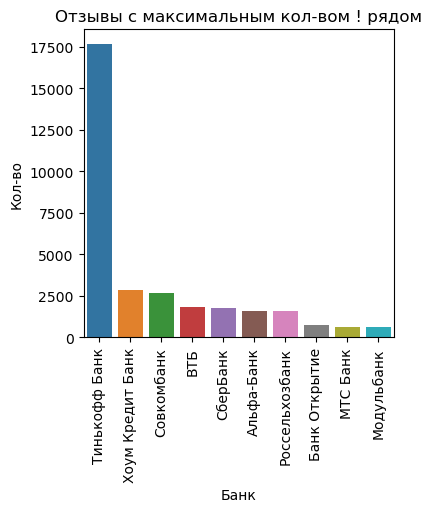

In [8]:
fig = plt.figure(figsize=(4,4), dpi=100)
sns.barplot(x = top_max_VoscZ.index, y = top_max_VoscZ.values)
plt.xticks(rotation = 90)
plt.xlabel('Банк')
plt.ylabel('Кол-во')
plt.title('Отзывы с максимальным кол-вом ! рядом');

In [9]:
# Отзывы, имеющие предложения, состоящие только из ! по топ-10 банков
top_only_VoscZ = df_comments.groupby('bank_name')['only_VoscZ'].sum().sort_values(ascending = False)[:10]
top_only_VoscZ

bank_name
Тинькофф Банк       45519
Хоум Кредит Банк    10491
Совкомбанк          10042
СберБанк             6995
ВТБ                  6980
Альфа-Банк           6131
Россельхозбанк       3691
Банк Открытие        2499
Газпромбанк          2323
МТС Банк             2220
Name: only_VoscZ, dtype: int64

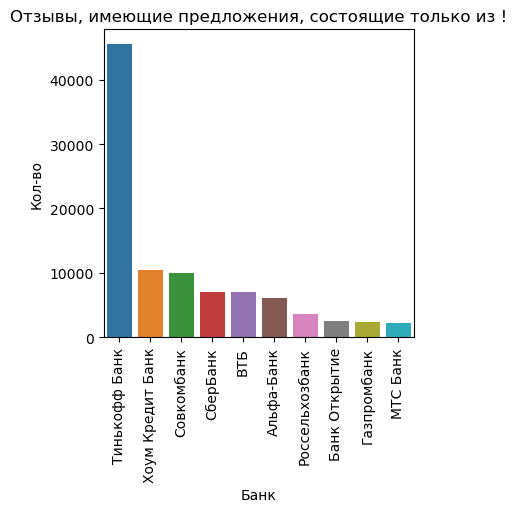

In [10]:
fig = plt.figure(figsize=(4,4), dpi=100)
sns.barplot(x = top_only_VoscZ.index, y = top_only_VoscZ.values)
plt.xticks(rotation = 90)
plt.xlabel('Банк')
plt.ylabel('Кол-во')
plt.title('Отзывы, имеющие предложения, состоящие только из !');

In [11]:
# топ-5 банков с отзывами, содержащими наибольшее кол-во уникальных слов
top_unique_word = df_comments.groupby('bank_name')['unique_word'].sum().sort_values(ascending = False)[:10]
top_unique_word

bank_name
Тинькофф Банк       44864
Хоум Кредит Банк     9310
Совкомбанк           6111
ВТБ                  3817
СберБанк             3490
Альфа-Банк           3369
Россельхозбанк       3064
Банк Открытие        1894
МТС Банк             1542
Модульбанк           1460
Name: unique_word, dtype: int64

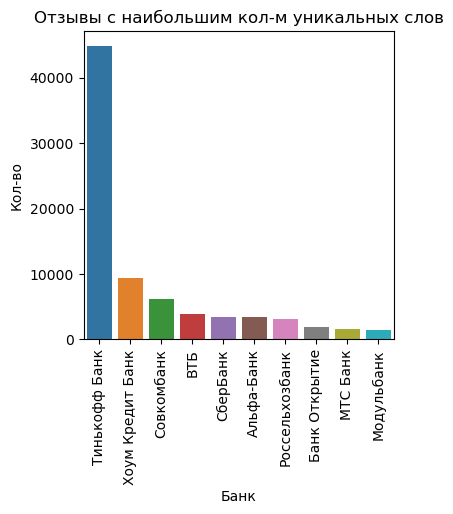

In [12]:
fig = plt.figure(figsize=(4,4), dpi=100)
sns.barplot(x = top_unique_word.index, y = top_unique_word.values)
plt.xticks(rotation = 90)
plt.xlabel('Банк')
plt.ylabel('Кол-во')
plt.title('Отзывы с наибольшим кол-м уникальных слов');

In [13]:
# Разделение на дату и время
df_comments['date'] = df_comments['date'].astype('datetime64')
df_comments = df_comments.assign(day = df_comments.date.dt.date)
df_comments = df_comments.assign(time = df_comments.date.dt.time)
df_comments.drop(columns = ['date'], axis = 1, inplace = True)

In [14]:
df_comments.head()

body  \
0  &lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...   
1  &lt;p&gt;При возврате просроченной задолженнос...   
2  &lt;p&gt;07.09.22 ю была оформлена кредитная к...   
3  &lt;p&gt;Новый год начинается с приятностей)&l...   
4  &lt;p&gt;Увидела на сайте Газпромбанка акцию с...   

                                               title  rating      bank_name  \
0                             Заблокировали средства       1      Еком Банк   
1                 Возврат просроченной задолженномти       1  Тинькофф Банк   
2  Ошибочное начисление комиссии, затягивание про...       1  Банк Открытие   
3                    Клиентоориентиванность 10 из 10       5  Тинькофф Банк   
4  Как Газпромбанк обманывает клиентов с акционны...       1    Газпромбанк   

   max_VoscZ  only_VoscZ  unique_word         day      time  
0          0           0            1  2023-01-03  12:46:11  
1          0           0            1  2023-01-03  12:31:46  
2          1          13            1  2023-01-03  12:23:11  
3          1           3            1  2023-01-03  12:16:07  
4          0           0            1  2023-01-03  12:12:36

In [15]:
# Очистка текста
df_comments['body'] = df_comments['body'].apply(lambda x: re.sub(r'&lt;.*?&gt;', "", str(x), flags=re.S))
df_comments['body'] = df_comments['body'].apply(lambda x: re.sub(u"[^.,а-яА-Я0-9]", " ", str(x)))

In [16]:
df_comments.head()

body  \
0  Добрый день  пишу сюда для более скорого разре...   
1  При возврате просроченной задолженности, банк ...   
2  07.09.22 ю была оформлена кредитная карта     ...   
3  Новый год начинается с приятностей   Никогда н...   
4  Увидела на сайте Газпромбанка акцию с бонусом ...   

                                               title  rating      bank_name  \
0                             Заблокировали средства       1      Еком Банк   
1                 Возврат просроченной задолженномти       1  Тинькофф Банк   
2  Ошибочное начисление комиссии, затягивание про...       1  Банк Открытие   
3                    Клиентоориентиванность 10 из 10       5  Тинькофф Банк   
4  Как Газпромбанк обманывает клиентов с акционны...       1    Газпромбанк   

   max_VoscZ  only_VoscZ  unique_word         day      time  
0          0           0            1  2023-01-03  12:46:11  
1          0           0            1  2023-01-03  12:31:46  
2          1          13            1  2023-01-03  12:23:11  
3          1           3            1  2023-01-03  12:16:07  
4          0           0            1  2023-01-03  12:12:36

In [17]:
'''
добавление статуса комментария, если его рейтинг больше или равен 3, то статус положительный,
если маньше 3, то отрицательный
'''

df_comments = df_comments.assign(status_comment = df_comments['rating'].apply(lambda x: 1 if x >= 3 else 0))

In [18]:
df_comments.head()

body  \
0  Добрый день  пишу сюда для более скорого разре...   
1  При возврате просроченной задолженности, банк ...   
2  07.09.22 ю была оформлена кредитная карта     ...   
3  Новый год начинается с приятностей   Никогда н...   
4  Увидела на сайте Газпромбанка акцию с бонусом ...   

                                               title  rating      bank_name  \
0                             Заблокировали средства       1      Еком Банк   
1                 Возврат просроченной задолженномти       1  Тинькофф Банк   
2  Ошибочное начисление комиссии, затягивание про...       1  Банк Открытие   
3                    Клиентоориентиванность 10 из 10       5  Тинькофф Банк   
4  Как Газпромбанк обманывает клиентов с акционны...       1    Газпромбанк   

   max_VoscZ  only_VoscZ  unique_word         day      time  status_comment  
0          0           0            1  2023-01-03  12:46:11               0  
1          0           0            1  2023-01-03  12:31:46               0  
2          1          13            1  2023-01-03  12:23:11               0  
3          1           3            1  2023-01-03  12:16:07               1  
4          0           0            1  2023-01-03  12:12:36               0

In [19]:
#Интересное наблюдение: больше всего положительных отзывов у Тинькофф
df_comm_group = df_comments.groupby('bank_name')['status_comment'].agg(np.sum).sort_values(ascending = False)[:5]
df_comm_group

bank_name
Тинькофф Банк       42708
Хоум Кредит Банк     8628
Совкомбанк           5057
Россельхозбанк       2643
Модульбанк           1396
Name: status_comment, dtype: int64

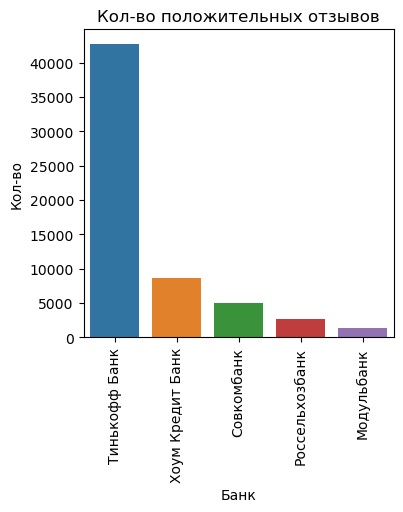

In [20]:
fig = plt.figure(figsize=(4,4), dpi=100)
sns.barplot(x = df_comm_group.index, y = df_comm_group.values)
plt.xticks(rotation = 90)
plt.xlabel('Банк')
plt.ylabel('Кол-во')
plt.title('Кол-во положительных отзывов');

In [21]:
#Интересное наблюдение: положительных отзывов в ~3.5 раза больше, чем отрицательных
df_comments['status_comment'].value_counts()

1    71892
0    20843
Name: status_comment, dtype: int64

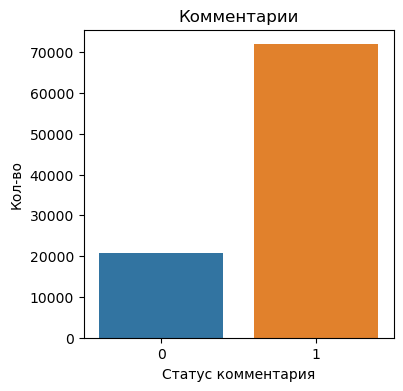

In [22]:
fig = plt.figure(figsize=(4,4), dpi=100)
sns.countplot(data = df_comments, x = 'status_comment')
plt.xlabel('Статус комментария')
plt.ylabel('Кол-во')
plt.title('Комментарии');

In [23]:
#  топ-15 банков по кол-ву отзывов
top_15_banks = df_comments['bank_name'].value_counts().sort_values(ascending = False)[:15]
top_15_banks

Тинькофф Банк                              44864
Хоум Кредит Банк                            9310
Совкомбанк                                  6111
ВТБ                                         3817
СберБанк                                    3490
Альфа-Банк                                  3369
Россельхозбанк                              3064
Банк Открытие                               1894
МТС Банк                                    1542
Модульбанк                                  1460
Газпромбанк                                 1314
Московский Кредитный Банк                   1251
Азиатско-Тихоокеанский Банк                 1001
Уральский Банк Реконструкции и Развития      748
Русский Стандарт                             689
Name: bank_name, dtype: int64

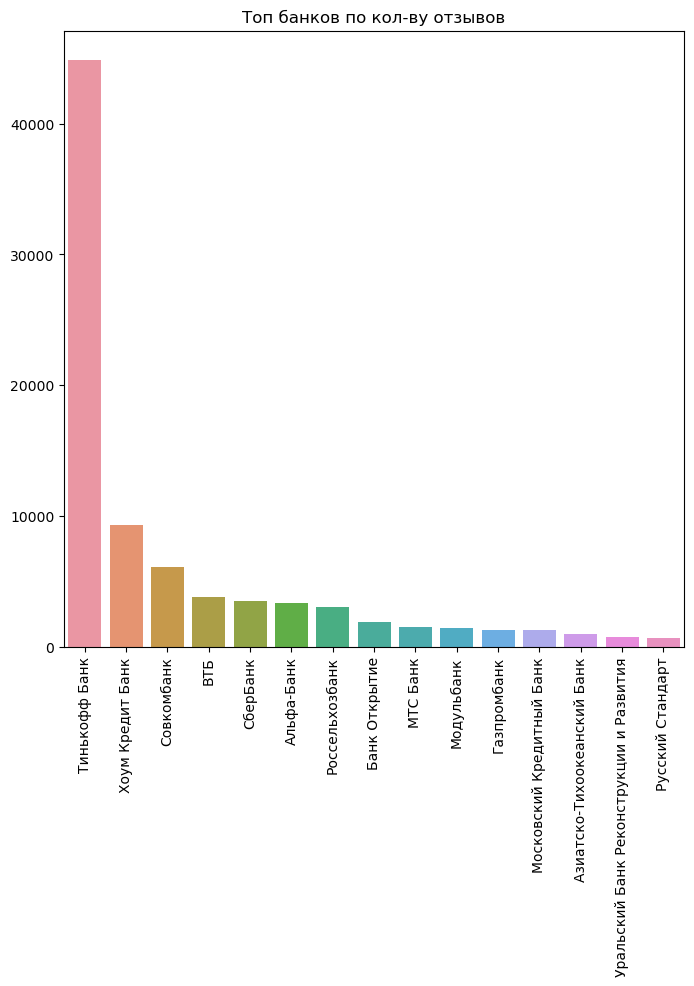

In [24]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.barplot(data = df_comments, x = top_15_banks.index, y = top_15_banks.values)
plt.xticks(rotation = 90)
plt.title("Топ банков по кол-ву отзывов");

In [25]:
# Банк из топ-15 с самым высоким средним рейтингом
df_sort_top_15 = df_comments.loc[df_comments['bank_name'].isin(top_15_banks.index)]
top_1_mean_rating = df_sort_top_15.groupby('bank_name')['rating'].mean().sort_values(ascending = False)[:1]
top_1_mean_rating

bank_name
Тинькофф Банк    4.783568
Name: rating, dtype: float64

In [26]:
#  Средний рейтинг у топ-15 банков
top_15_mean_rating = df_sort_top_15.groupby('bank_name')['rating'].mean().sort_values(ascending = False)
top_15_mean_rating

bank_name
Тинькофф Банк                              4.783568
Модульбанк                                 4.780137
Азиатско-Тихоокеанский Банк                4.718282
Хоум Кредит Банк                           4.505585
Россельхозбанк                             4.455940
Совкомбанк                                 4.264768
Московский Кредитный Банк                  4.241407
Русский Стандарт                           4.158200
Банк Открытие                              3.543295
Уральский Банк Реконструкции и Развития    3.298128
МТС Банк                                   2.901427
СберБанк                                   2.303725
Газпромбанк                                2.145358
ВТБ                                        1.950223
Альфа-Банк                                 1.714159
Name: rating, dtype: float64

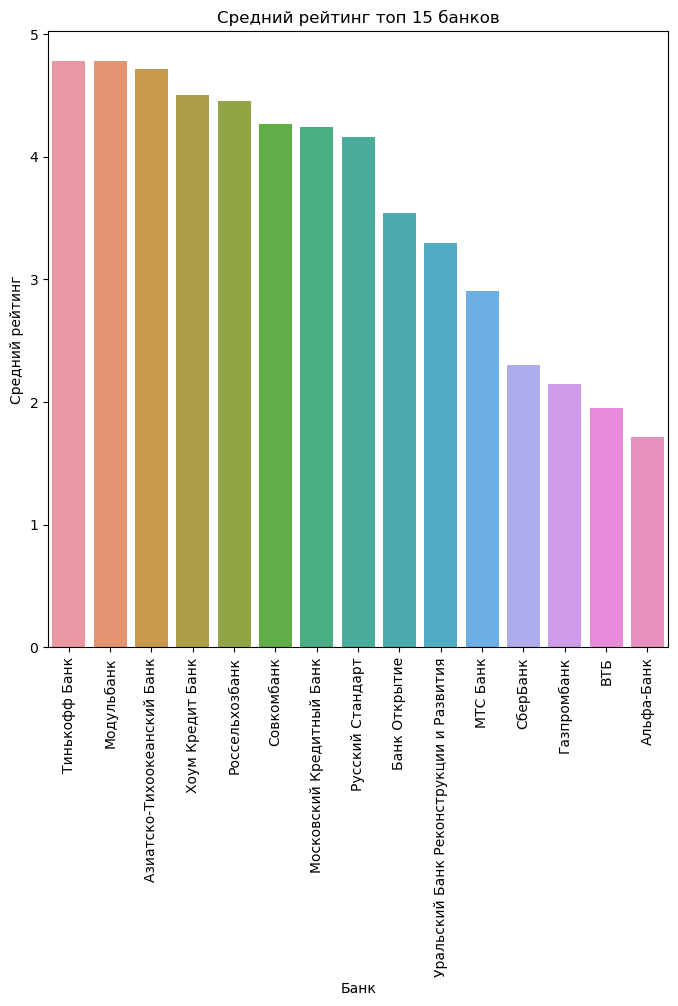

In [27]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.barplot(data = df_sort_top_15, x = top_15_mean_rating.index, y = top_15_mean_rating.values)
plt.xticks(rotation = 90)
plt.title('Средний рейтинг топ 15 банков')
plt.xlabel('Банк')
plt.ylabel('Средний рейтинг');

In [28]:
# топ-5 банков со средним рейтингом по месяцам
top_5_banks = df_comments['bank_name'].value_counts().sort_values(ascending = False)[:5]
df_sort_top_5 = df_comments.loc[df_comments['bank_name'].isin(top_5_banks.index)]
top_5 = df_sort_top_5[['bank_name', 'rating', 'day']]
top_5['day'] = top_5['day'].astype('datetime64')
top_5['month'] = top_5['day'].dt.month
top_5.drop(columns = ['day'], axis = 1, inplace = True)

top_5_pivot = pd.pivot_table(top_5,
              index = ['bank_name'],
              columns = ['month'],
              aggfunc = [np.mean],       
              margins=True)

In [29]:
#Странность: отсутствуют данные с февраля по август
"""
Интересные наблюдения: 

    1. Общий средний рейтинг у топ-5 банков выше всего в октябре и далее сползает к Новому году;
    
    2. Такие банки, как ВТБ и Сбербанк имеют самые низкие из топ-5 средние за 5 месяцев рейтинги, несмотря на то,
        что являются самыми популярными (по количеству пользователей) банками страны.
    
    3. Стоит задаться вопросом почему в этой выгрузке так много отзывов о "Тинькофф" (44'864 отзыва), причем
       преимущественно положительных (а клиенты не особо горят желанием тратить своё время на то, чтобы куда-то зайти
       и похвалить, а не пожаловаться), а у Сбера так мало - 3'490 отзывов, при том, что клиентов у Сбера в ~4.5 раза
       больше. Возможно, Тинькофф просит клиентов оставлять хороший отзыв после решения проблемы или просто рассылкой
       напоминалок. Если так - сет сильно искажен и выводы по нему делать некорректно. Для выравнивания датасета нужно
       и Сберу начать предлагать оставить хорошие отзывы, собрать полгода данных, и тогда уже смотреть на цифры и делать
       выводы.
       Если же считаем, что датасет корректен, и работаем "с тем, что есть", то идём дальше.
    
Возможны несколько причин низкого среднего рейтинга ВТБ и Сбербанка:
    
    1. Слабая подготовка персонала, возможно, отсутствие должной мотивации. Неспособность предложить решение;
    
    2. В случаях, когда решение предложено - некорректное донесение информации до клиента и вызванные этим проблемы;
    
    3. Возможно общее недовольство платностью услуг (комиссии за смс-уведомления) и их подключением "по умолчанию", 
       лимитами на снятия и бесплатные переводы, необходимостью лично посещать офис для решения, по мнению клиента,
       простых вопросов;
       
    4. Принимаемые банками решения об оптимизации, негативно сказывающиеся на комфорте клиентов, что,
       в свою очередь, приводит к недовольству;
       
    5. Часто не работающие предложения (на примере Сбера - Сбербанк Инвестор, СБОЛ);
    
    6. Неудовлетворительная работа новых направлений (на примере Сбера - СберМегамаркет с постоянными задержками
       доставки и отменами заказов, неспособностью решить простые проблемы вроде добавления адреса в список допустимых
       адресов доставки);
    
Выводы по изменению средних значений по месяцам:

    1. В январе наблюдается негативная динамика у большинства банков, что может быть связано с незакрытыми вопросами
       клиентов, которые те намеревались закрыть к концу года, но в итоге вынуждены были ждать окончания праздников.
       Плюс, вероятно, по вопросамм, возникшим в январские праздники, время предоставления ответа увеличено;
       
    2. В декабре у всех банков наблюдается положительная динамика относительно января, что может говорить о
       переосмыслении и улучшении качества работы с клиентами в течении года. Однако, это предположение следует
       проверить на январских рейтингах следующего года. 
        
       Если ВТБ и Сбербанк по-прежнему сохранят низкие рейтинги (радикального улучшения на годовом горизонте не видно),
       можно будет сделать вывод, что начинать улучшение работы в этом направлении нужно не с работы с клиентами,
       а с работы организаций с собственными сотрудниками (тренинги, корректная справедливая мотивация).
"""

top_5_pivot

mean                                                  
                    rating                                                  
month                    1         9        10        11        12       All
bank_name                                                                   
ВТБ               1.148148  2.073814  1.914620  1.993778  1.896052  1.950223
СберБанк          1.400000  1.920000  2.777547  2.562708  1.868263  2.303725
Совкомбанк        4.419355  3.883544  3.846561  4.230511  4.524676  4.264768
Тинькофф Банк     3.990291  3.888102  4.865877  4.841598  4.650189  4.783568
Хоум Кредит Банк  2.833333  4.060465  3.591479  4.001401  4.626306  4.505585
All               3.272727  3.324388  4.588670  4.513504  4.333490  4.410330

In [30]:
# Приведение в удобоэксплуатируемый вид для дальнейших расчётов
top_5_pivot = pd.pivot_table(top_5,
              index = ['bank_name'],
              columns = ['month'],
              aggfunc = [np.mean])
df_top_5_pivot = top_5_pivot.unstack().reset_index(name='value').drop(['level_0', 'level_1'], axis=1) \
                            .rename(columns = {'value': 'mean_rating'}).round(2)

In [31]:
# Подготовка к построению модели бинарной классификации

# Приведение значений в столбце body к нижнему регистру
df_comments['body'] = df_comments['body'].apply(lambda x: x.lower())

"""
    1. избавление от букв латинского алфавита, чисел, знаков препинания и всех символов;
    2. разбиение на токены;
    3. проведение лемматизации;
    4. удаление стоп-слов.

"""
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df_comments['body'] = df_comments['body'].apply(lemmatize)

df_comments = df_comments.dropna(subset = ['body'])
df_comments['body'] = df_comments['body'].apply(lambda x: ' '.join(x))

In [32]:
df_comments.head()

body  \
0  добрый день писать сюда скорый разрешение вопр...   
1  возврат просрочить задолженность банк звонить ...   
2  ю оформить кредитный карта день банк открытие ...   
3  новый год начинаться приятность понимать челов...   
4  увидеть сайт газпромбанк акция бонус кредитный...   

                                               title  rating      bank_name  \
0                             Заблокировали средства       1      Еком Банк   
1                 Возврат просроченной задолженномти       1  Тинькофф Банк   
2  Ошибочное начисление комиссии, затягивание про...       1  Банк Открытие   
3                    Клиентоориентиванность 10 из 10       5  Тинькофф Банк   
4  Как Газпромбанк обманывает клиентов с акционны...       1    Газпромбанк   

   max_VoscZ  only_VoscZ  unique_word         day      time  status_comment  
0          0           0            1  2023-01-03  12:46:11               0  
1          0           0            1  2023-01-03  12:31:46               0  
2          1          13            1  2023-01-03  12:23:11               0  
3          1           3            1  2023-01-03  12:16:07               1  
4          0           0            1  2023-01-03  12:12:36               0

In [34]:
# Выделение независимой и целевой переменной
y = df_comments['status_comment'].values
X = df_comments['body']

#Разделение на тренировочную, тестовую, валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Создание классификатора, обучение
knb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])
knb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

In [35]:
# Предсказание на тестовой выборке, получение метрик
predicted_knb = knb.predict(X_test)
print(metrics.classification_report(predicted_knb, y_test))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3848
           1       0.95      0.96      0.95     12840

    accuracy                           0.93     16688
   macro avg       0.90      0.89      0.90     16688
weighted avg       0.93      0.93      0.93     16688



In [ ]:
"""
    В связи с тем, что датасет не сбалансирован, метрику «accuracy» использовать нельзя, 
    так как это приведет к завышенной оценке качества работы классификатора. В данном случае самое правильное – считать
    сразу несколько метрик, устойчивых к распределению классов (в данном случае, это — точность, полнота и f-мера)
    и смотреть на них все. В нашей задаче лучше всего подходит «macro-avg», она более устойчива к скошенным
    распределениям классов.
"""

Text(0.5, 0, 'К-соседей')

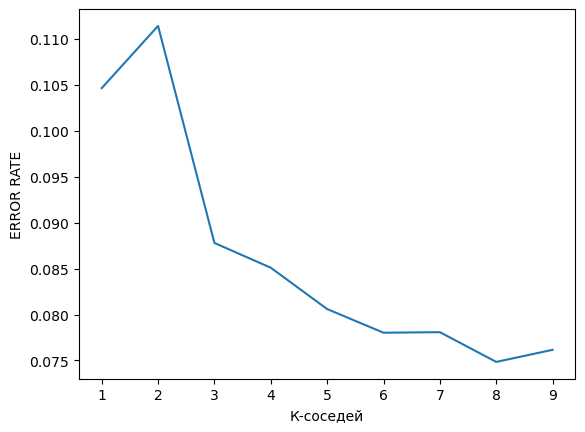

In [44]:
# Подбор гипер-параметра К

test_error_rates = []

for k in range(1,10):
    knb_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('knb_clf', KNeighborsClassifier(n_neighbors=k))])
    knb_model.fit(X_train, y_train)
    y_pred_knb = knb_model.predict(X_test)
    
    test_error = 1 - accuracy_score(y_test, y_pred_knb)
    test_error_rates.append(test_error)

plt.plot(range(1,10), test_error_rates)
plt.ylabel('ERROR RATE')
plt.xlabel('К-соседей')

In [46]:
# Методом "локтя" выбираем число соседей 6
knb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('knb_clf', KNeighborsClassifier(n_neighbors=6))])
knb.fit(X_train, y_train)
predicted_knb = knb.predict(X_test)
print(metrics.classification_report(predicted_knb, y_test))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4140
           1       0.93      0.96      0.95     12548

    accuracy                           0.92     16688
   macro avg       0.90      0.88      0.89     16688
weighted avg       0.92      0.92      0.92     16688



In [47]:
# Обучение валидационной выборки, расчёт метрик
predicted_knb_val = knb.predict(X_valid)
print(metrics.classification_report(predicted_knb_val, y_valid))

# Получены отличные результаты, модель работает корректно, не переобучена

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2326
           1       0.93      0.96      0.95      6946

    accuracy                           0.92      9272
   macro avg       0.91      0.88      0.89      9272
weighted avg       0.92      0.92      0.92      9272



In [50]:
# Проверка работы модели на метрике roc-auc. Насколько хорошо происходит распределение по классам при увеличении признаков

import scipy.sparse as sp

df_comments['max_VoscZ'] = df_comments['max_VoscZ'] / df_comments['max_VoscZ'].max()
df_comments['only_VoscZ'] = df_comments['only_VoscZ'] / df_comments['only_VoscZ'].max()
df_comments['unique_word'] = df_comments['unique_word'] / df_comments['unique_word'].max()
df_comments[df_comments['only_VoscZ'] > 0]

y2 = df_comments['status_comment'].values
vectorizer = TfidfVectorizer(min_df = 3000)
X2 = vectorizer.fit_transform(df_comments['body'])
X2 = sp.hstack([X2, sp.csr_matrix(df_comments['max_VoscZ'].values).T], 'csr')
X2 = sp.hstack([X2, sp.csr_matrix(df_comments['only_VoscZ'].values).T], 'csr')
X2 = sp.hstack([X2, sp.csr_matrix(df_comments['unique_word'].values).T], 'csr')

X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=0.1, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_train, y2_train, test_size=0.2, random_state=42)

knb2 = KNeighborsClassifier(n_neighbors=6).fit(X2_train, y2_train)
roc_auc_score(y2_test, knb2.predict(X2_test))

0.8772026407747214

In [51]:
roc_auc_score(y2_valid, knb2.predict(X2_valid))

0.8796651203561517